In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from callbacks import ValPlotCallback
from model import make_model
from keras.layers import Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm

import numpy as np
import glob
import cv2
import os
from pathlib import Path
import random

from helpers import image_splitter, print_array_properties, image_checker, image_tester, create_batches, batch_stacker


%matplotlib inline

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
train_image_dir = 'images/training/build/0/'
train_mask_dir = 'images/training/mask/0/'
test_image_dir = 'images/training/test/0/'
data_dir = 'data/'


In [22]:
SEED = 77

# ======Image Splitter Params ====== #
split_rows = 200
split_cols = 200
resize = True
image_resize_width = 1200
image_resize_height = 1200

images_per_batch = 6  # decrease this number if running out of memory
train_val_split_size = 0.1
# ======================= MODEL PARAMS ======================= #
epochs = 5
model_batch_size = 8
model_name = 'datagenmodel'
model_path = os.path.join(data_dir, model_name + '.hdf5')
pretrained_model = False
pretrained_model_path = model_path
print_model_summary_on_compile = False
plot_epoch_val_images = True

# ==================== Data Augmentation ==================== #
data_augmentation = False
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    # randomly rotate images in the range (degrees, 0 to 180)
    rotation_range=60,
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.2,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.2,
    shear_range=0.0,  # set range for random shear
    zoom_range=0.0,  # set range for random zoom
    channel_shift_range=0.0,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.0,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format='channels_last',
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0,
)

# ==================== Callbacks ==================== #
early_stop = EarlyStopping(patience=5, verbose=1)
check_point = ModelCheckpoint(
    os.path.join(data_dir, model_name + '.hdf5'), save_best_only=True, verbose=1
)
tensor_board = TensorBoard(
    log_dir='../logs/tensorboard/',
    histogram_freq=1,
    write_graph=True,
    write_grads=False,
    write_images=True,
    embeddings_freq=1,
    update_freq='epoch',
)


BATCH NUMBER 1
X_TRAIN
Length: 5
Shape: (5, 1200, 1200, 3)
Size: 0.08 GB

Y_TRAIN
Length: 5
Shape: (5, 1200, 1200, 1)
Size: 0.027 GB

X_VAL
Length: 1
Shape: (1, 1200, 1200, 3)
Size: 0.016 GB

Y_VAL
Length: 1
Shape: (1, 1200, 1200, 1)
Size: 0.005 GB

Creating New Model
Not using data augmentation.
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.8319 - accuracy: 0.4442
Epoch 1: val_loss improved from inf to 0.59399, saving model to data/datagenmodel.hdf5
1/1 [==============================] - 25s 25s/step - loss: 0.8319 - accuracy: 0.4442 - val_loss: 0.5940 - val_accuracy: 0.7184
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.7050
Epoch 2: val_loss improved from 0.59399 to 0.58636, saving model to data/datagenmodel.hdf5
1/1 [==============================] - 21s 21s/step - loss: 0.5981 - accuracy: 0.7050 - val_loss: 0.5864 - val_accuracy: 0.7555
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.

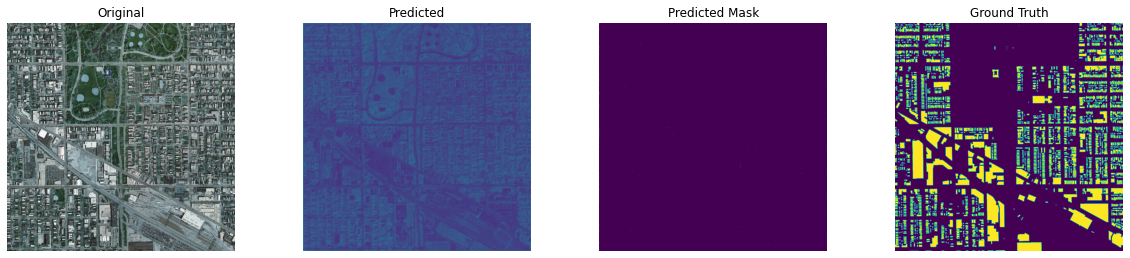

BATCH NUMBER 2
Loading Trained Model
Not using data augmentation.
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.4920 - accuracy: 0.8181
Epoch 1: val_loss improved from 0.58510 to 0.48806, saving model to data/datagenmodel.hdf5
1/1 [==============================] - 21s 21s/step - loss: 0.4920 - accuracy: 0.8181 - val_loss: 0.4881 - val_accuracy: 0.8116
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.4886 - accuracy: 0.8178
Epoch 2: val_loss improved from 0.48806 to 0.47896, saving model to data/datagenmodel.hdf5
1/1 [==============================] - 21s 21s/step - loss: 0.4886 - accuracy: 0.8178 - val_loss: 0.4790 - val_accuracy: 0.8116
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.8185
Epoch 3: val_loss improved from 0.47896 to 0.47361, saving model to data/datagenmodel.hdf5
1/1 [==============================] - 21s 21s/step - loss: 0.4817 - accuracy: 0.8185 - val_loss: 0.4736 - val_accuracy: 0.8116
Epoc

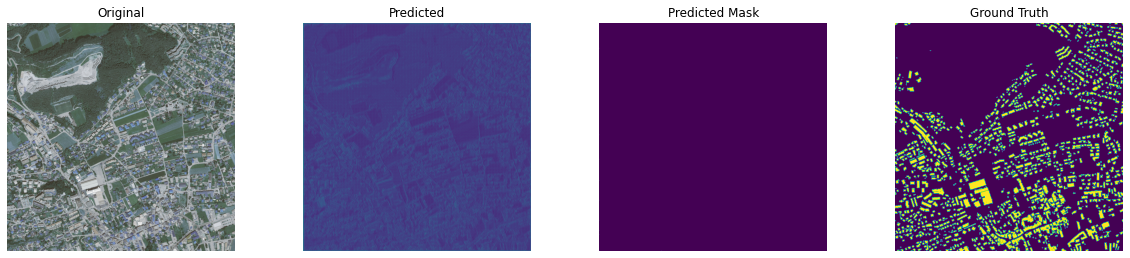

BATCH NUMBER 3
Loading Trained Model
Not using data augmentation.
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.8197
Epoch 1: val_loss improved from 0.47361 to 0.29296, saving model to data/datagenmodel.hdf5
1/1 [==============================] - 22s 22s/step - loss: 0.4754 - accuracy: 0.8197 - val_loss: 0.2930 - val_accuracy: 0.9140
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8207
Epoch 2: val_loss improved from 0.29296 to 0.28413, saving model to data/datagenmodel.hdf5
1/1 [==============================] - 21s 21s/step - loss: 0.4671 - accuracy: 0.8207 - val_loss: 0.2841 - val_accuracy: 0.9141
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.8211
Epoch 3: val_loss improved from 0.28413 to 0.27521, saving model to data/datagenmodel.hdf5
1/1 [==============================] - 22s 22s/step - loss: 0.4577 - accuracy: 0.8211 - val_loss: 0.2752 - val_accuracy: 0.9141
Epoc

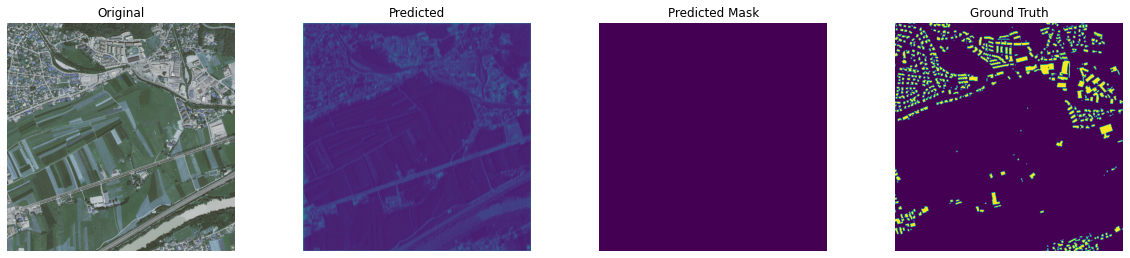

BATCH NUMBER 4
Loading Trained Model
Not using data augmentation.
Epoch 1/5


KeyboardInterrupt: 

In [23]:
train_path = Path(train_image_dir)
mask_path = Path(train_mask_dir)

filenames = [f.name for f in train_path.glob('*.tif')]
# does this help training?
random.shuffle(filenames)

train_files = [str(train_path / name) for name in filenames]
mask_files = [str(mask_path / name) for name in filenames]

train_img_batches = create_batches(train_files, batch_size=images_per_batch)
train_mask_batches = create_batches(mask_files, batch_size=images_per_batch)

train_stack = batch_stacker(train_img_batches, resize=(image_resize_width, image_resize_width))
mask_stack = batch_stacker(train_mask_batches, resize=(image_resize_width, image_resize_width), gray=True)

for batch_number, (train_batch, mask_batch) in enumerate(zip(train_stack, mask_stack), start=1):
    print(f'BATCH NUMBER {batch_number}')

    x_train, x_val, y_train, y_val = train_test_split(
        train_batch, mask_batch, random_state=SEED, test_size=train_val_split_size
    )
    if batch_number == 1:
        print_array_properties('x_train', x_train)
        print_array_properties('y_train', y_train)
        print_array_properties('x_val', x_val)
        print_array_properties('y_val', y_val)

    inputs = Input(shape=(x_train.shape[1:]))
    
    if pretrained_model or batch_number > 1:
        print('Loading Trained Model')
        model = load_model(pretrained_model_path)
    else:
        print('Creating New Model')
        model = make_model(inputs=inputs, model_name=model_name, print_summary=False)

    # =================== MODEL PARAMS =================== #
    validation_plots = ValPlotCallback(model, model_batch_size, x_val, y_val)
    model_fit_params = dict(
        batch_size=model_batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=1,
        steps_per_epoch=max(x_train.shape[0] // model_batch_size, 1),
        validation_steps=max((x_train.shape[0] // model_batch_size) * train_val_split_size, 1),
        callbacks=[early_stop, check_point, tensor_board, validation_plots],
    )
    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(x_train, y_train, **model_fit_params)
    else:
        print('Augmenting Data')

        # provide the same seed and keyword arguments
        image_datagen = ImageDataGenerator(**datagen_args)
        mask_datagen = ImageDataGenerator(**datagen_args)

        image_datagen.fit(x_train, augment=True, seed=SEED)
        mask_datagen.fit(y_train, augment=True, seed=SEED)

        # save_to_dir='../images/augmented/images/',
        # save_to_dir='../images/augmented/masks/',
        image_generator = image_datagen.flow(x_train, seed=SEED)
        mask_generator = mask_datagen.flow(y_train, seed=SEED)

        train_generator = zip(image_generator, mask_generator)

        model.fit(train_generator, **model_fit_params)
        if batch_number == 1:
            # otherwise possibly load an old model on second epoch
            model.save(model_path)


In [ ]:
# ================================================================ #
# ========================== VALIDATION ========================== #

x_val_pred = model.predict(x_val, verbose=1, batch_size=model_batch_size)

model.evaluate(x=x_val, y=y_val, batch_size=model_batch_size)

# simple threshold to change to 1/0, mask
x_val_pred_mask = (x_val_pred > 0.5).astype(np.uint8)

In [ ]:
plot_predictions(original=x_val, predicted=x_val_pred,
                 predicted_mask=x_val_pred_mask, ground_truth=y_val)

In [ ]:
# model = load_model('../data/testing_model.h5')

In [ ]:
# ================================================================ #
# ========================== PREDICTION ========================== #


x_test = [np.array(
    image_splitter(
        cv2.imread(test_image_dir + img_name).astype(np.uint8),
        num_col_splits=split_cols,
        num_row_splits=split_rows,
        resize=resize,
        resize_height=image_resize_height,
        resize_width=image_resize_width
    )
) for img_name in tqdm(test_filenames[:20])]

x_test = (np.vstack(x_test)/255).astype(np.float32)

shape_and_mem(x_test)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(x_test, seed=seed)

y_pred = model.predict(test_generator, verbose=1)

shape_and_mem(y_pred)

y_pred_mask = (y_pred > 0.5).astype(np.uint8)

In [ ]:
plot_predictions(original=x_test, predicted=y_pred,
                 predicted_mask=y_pred_mask)


# https://www.jeremyjordan.me/evaluating-image-segmentation-models/

# result = cv2.bitwise_and(test_split[0], test_split[0], mask=prediction[0])

# result

In [ ]:
# https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

# https://www.jeremyjordan.me/evaluating-image-segmentation-models/

